# Sandbox

In [16]:
import numpy as np
import qutip as qt
import torch
import matplotlib.pyplot as plt
import sys
import os
import importlib

In [48]:
sys.path.append('..')

In [49]:
import alpha_zero as az
import pulse_sequences as ps

In [4]:
# importlib.reload(az)
importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

## Make decay plots

In [34]:
c48 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_1.csv', delimiter=',')
whh = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_2.csv', delimiter=',')
fid = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_3.csv', delimiter=',')
c48 = np.concatenate([[[0, 1]], c48])
whh = np.concatenate([[[0, 1]], whh])
fid = np.concatenate([[[0, 1]], fid])

In [40]:
cory48_1 = np.loadtxt('../../data/2021-03/Experimental/2021-03-13/c48_3_13.csv', delimiter=',')
yxx48 = np.loadtxt('../../data/2021-03/Experimental/2021-03-13/yxx48.csv', delimiter=',')
az48 = np.loadtxt('../../data/2021-03/Experimental/2021-03-13/az48.csv', delimiter=',')
cory48_1 = np.concatenate([[[0, 1]], cory48_1])
yxx48 = np.concatenate([[[0, 1]], yxx48])
az48 = np.concatenate([[[0, 1]], az48])

In [41]:
cory48_2 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/comp_linear_1.csv', delimiter=',')
yxx48_2 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/yxx48_6.csv', delimiter=',')
az48_2 = np.loadtxt('../../data/2021-03/Experimental/2021-03-18/az48_6.csv', delimiter=',')
cory48_2 = np.concatenate([[[0, 1]], cory48_2])
yxx48_2 = np.concatenate([[[0, 1]], yxx48_2])
az48_2 = np.concatenate([[[0, 1]], az48_2])

In [20]:
# default figure size is [6.0, 4.0]
plt.rcParams['figure.figsize'] = [4, 2.67]
# default dpi is 72
plt.rcParams['figure.dpi'] = 144

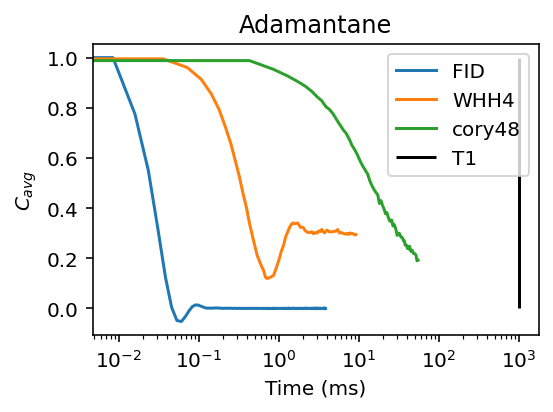

In [81]:
# plt.ylim(0, 1)
plt.plot(fid[:, 0], fid[:, 1], label='FID')
plt.plot(whh[:, 0], whh[:, 1], label='WHH4')
plt.plot(c48[:, 0], c48[:, 1], label='cory48')

# from 3/13 experiments
# plt.plot(cory48_1[:, 0], cory48_1[:, 1], label='cory48')
# plt.plot(yxx48[:, 0], yxx48[:, 1], label='yxx48')
# plt.plot(az48[:, 0], az48[:, 1], label='az48/AHT')

# from 3/18 experiments
# plt.plot(cory48_2[:, 0], cory48_2[:, 1], label='cory48 2')
# plt.plot(yxx48_2[:, 0], yxx48_2[:, 1], label='yxx48 2')
# plt.plot(az48_2[:, 0], az48_2[:, 1], label='az48/AHT 2')

plt.vlines(x=1e3, ymin=0, ymax=1, colors='k', label='T1')

plt.xscale('log')
plt.title('Adamantane')
plt.xlabel('Time (ms)')
plt.ylabel(r'$C_{avg}$')
plt.legend()
plt.savefig('decay_plot_1.pdf', bbox_inches='tight')

## Bloch sphere representations

In [156]:
from scipy.spatial.transform import Rotation

In [147]:
b = qt.Bloch()

In [151]:
z = qt.ket([0])
y = (qt.ket([0]) + 1j * qt.ket([1])).unit()

In [152]:
b.add_states([z, y])

In [162]:
# b.show()

In [154]:
x = np.array([0, 0, 1])

In [157]:
Rx = Rotation.from_euler('x', 5, degrees=True).as_matrix()
Ry = Rotation.from_euler('y', 5, degrees=True).as_matrix()

In [158]:
states = [np.linalg.matrix_power(Ry, i) @ x for i in range(10)]

In [159]:
xp, yp, zp = zip(*[(i[0], i[1], i[2]) for i in states])

In [160]:
# b.add_vectors(x)
# b.add_points(x)
b.add_points([xp, yp, zp])

In [25]:
b.save('test.png')

## Simulating decay plots

In [155]:
N = 3
dipolar_strength = 10
pulse_width = .002
delay = .008

In [6]:
Hsys = ps.get_Hsys(N=N, dipolar_strength=dipolar_strength)

In [58]:
X, Y, Z = ps.get_collective_spin(N=N)

In [9]:
Utarget = qt.identity([2]*N)

In [12]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=pulse_width, delay=delay)

In [16]:
U_cory48 = ps.get_propagator(ps.cory48, pulses)

In [17]:
U_yxx48 = ps.get_propagator(ps.yxx48, pulses)

In [19]:
U_az48 = ps.get_propagator(ps.az48_1, pulses)

In [151]:
# the first-order correction to the thermal density matrix is X
rho0 = X

In [154]:
# scale the signal amplitude by initial signal amplitude
S0 = qt.expect(X, rho0)
S0

6.0

In [156]:
T_cory48 = (pulse_width + delay) * len(ps.cory48)

In [158]:
T_yxx48 = (pulse_width + delay) * len(ps.yxx48)

In [189]:
T_az48 = (pulse_width + delay) * len(ps.az48_1)

In [180]:
S_cory48 = qt.expect(X, [U_cory48**i * rho0 * U_cory48.inv()**i for i in range(100)])

In [181]:
S_yxx48 = qt.expect(X, [U_yxx48**i * rho0 * U_yxx48.inv()**i for i in range(100)])

In [188]:
S_az48 = qt.expect(X, [U_az48**i * rho0 * U_az48.inv()**i for i in range(100)])

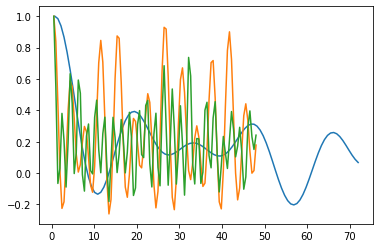

In [190]:
plt.plot(np.cumsum([T_cory48] * len(S_cory48)), np.real(S_cory48) / S0)
plt.plot(np.cumsum([T_yxx48] * len(S_yxx48)), np.real(S_yxx48) / S0)
plt.plot(np.cumsum([T_az48] * len(S_az48)), np.real(S_az48) / S0)

## Testing network

In [46]:
Utarget = qt.identity([2] * 3)

In [50]:
config = az.Config()

In [51]:
ps_config = ps.PulseSequenceConfig(Utarget=Utarget, max_sequence_length=48, ensemble_size=50)

In [52]:
net = az.Network()
net.load_state_dict(torch.load('../../data/2021-03/20210318-001837/network/0015500'))

<All keys matched successfully>

In [53]:
sequence = []
for _ in range(48):
    net_out = net(az.one_hot_encode(sequence).unsqueeze(0))
    sequence.append(np.argmax(net_out[0].detach().numpy()))

In [55]:
print(sequence[:48])

[1, 0, 3, 3, 3, 1, 0, 0, 2, 2, 1, 1, 4, 4, 4, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 0, 0, 4, 0, 0, 4, 0, 0]


In [57]:
net(az.one_hot_encode(sequence[:2]).unsqueeze(0))

(tensor([[0.2149, 0.2074, 0.0977, 0.4063, 0.0737]], grad_fn=<SoftmaxBackward>),
 tensor([[0.6596]], grad_fn=<AddmmBackward>),
 tensor([[[ 0.0184,  0.4001,  0.1349, -0.2431, -0.0820,  0.0110, -0.0622,
           -0.1905,  0.1547,  0.0031,  0.1600, -0.1841, -0.1064, -0.2506,
            0.0934,  0.0312,  0.0270, -0.2000, -0.0877,  0.0168, -0.0415,
           -0.0358, -0.1301, -0.0084, -0.0830, -0.1243, -0.2367, -0.0779,
            0.3372, -0.3977,  0.4100, -0.0324, -0.3736,  0.0365, -0.1006,
            0.0177, -0.0322,  0.0018,  0.2675, -0.0396,  0.0291, -0.0697,
           -0.1504, -0.1543,  0.0702,  0.4483, -0.2244,  0.1941,  0.0082,
           -0.0039,  0.0846, -0.2025,  0.2286, -0.2651, -0.2567, -0.1328,
            0.1296,  0.1194, -0.2189, -0.1830, -0.1389,  0.2297,  0.1967,
           -0.6680]]], grad_fn=<StackBackward>))

In [75]:
ps_config.reset()
output = az.make_sequence(config, ps_config, network=net, test=True,
                          rng=ps_config.rng, enforce_aht_0=True, max_difference=1)

In [76]:
print(output[-1])

([1, 4, 1, 4, 1, 4, 3, 3, 1, 1, 3, 1, 4, 1, 3, 3, 3, 1, 3, 4, 1, 1, 4, 1, 3, 1, 1, 3, 1, 1, 3, 4, 1, 1, 4, 1, 3, 2, 3, 3, 3, 2, 3, 1, 4, 4, 4], array([0., 1., 0., 0., 0.]), 1.6515496985335831)


In [74]:
ps.count_axes(output[-1][0])

[8, 8, 8, 7, 8, 8]

In [71]:
ps.count_axes([3, 3, 3, 1, 3, 3])

[1, 1, 1, 1, 1, 1]

## Testing ps_config parameter saving

In [216]:
output = np.load('../scripts/ps_config-0-no_net.npz')

In [222]:
np.std(output['rots'])

0.009820976650951307

In [202]:
cs = output['chemical_shifts']
dip_mat = output['dipolar_matrices']

In [203]:
N=3

In [204]:
Hsys_ensemble = []
offset = 0
for chemical_shifts, dipolar_matrix in zip(cs, dip_mat):
    Hcs = sum(
        [qt.tensor(
            [qt.identity(2)] * i
            + [(offset + chemical_shifts[i]) * qt.sigmaz()]
            + [qt.identity(2)] * (N - i - 1)
        ) for i in range(N)]
    )
    # dipolar interactions
    Hdip = sum([
        dipolar_matrix[i, j] * (
            2 * qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmaz()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmaz()]
                + [qt.identity(2)] * (N - j - 1)
            )
            - qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmax()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmax()]
                + [qt.identity(2)] * (N - j - 1)
            )
            - qt.tensor(
                [qt.identity(2)] * i
                + [qt.sigmay()]
                + [qt.identity(2)] * (j - i - 1)
                + [qt.sigmay()]
                + [qt.identity(2)] * (N - j - 1)
            )
        )
        for i in range(N) for j in range(i + 1, N)
    ])
    
    Hsys_ensemble.append(Hcs + Hdip)

In [213]:
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=0.01)
    pulses_ensemble.append(
        ps.get_pulses(H, X, Y, Z, pulse_width=1e-5, delay=1e-4, rot_error=rot)
    )

In [214]:
f = ps.get_mean_fidelity([3, 4, 4, 2, 4, 4, 2, 2, 3, 3, 2, 3], Utarget, pulses_ensemble)
-np.log10(1 - f)

2.5015571286258496

## Simulation

In [83]:
Hsys, params = ps.get_Hsys(N=3, offset=1e0, dipolar_strength=1e2, return_all=True)

In [84]:
X, Y, Z = ps.get_collective_spin(N=3)

In [88]:
output = qt.mesolve(Hsys, X, tlist=np.linspace(0, 15e-2, 500), e_ops=[X, Y, Z])

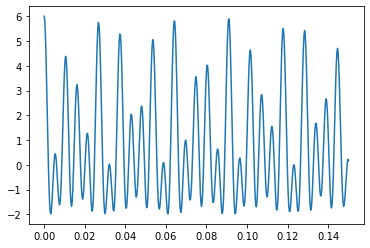

In [89]:
plt.plot(output.times, output.expect[0])

In [90]:
params

(array([0.56365476, 0.13010873, 0.8971216 ]),
 0.20856764728178212,
 array([[-127.71305054, -145.45596682,   84.50100052],
        [ -17.43951414,  101.06205672,   26.8447102 ],
        [-181.97074045,  -41.18745734,  -14.02630326]]))

In [123]:
pulses = ps.get_pulses(Hsys, X, Y, Z, pulse_width=1e-5, delay=1e-4, phase_transient=0)

In [122]:
(pulses[1] * pulses[1] * pulses[1] * pulses[1]).tr()/8

(-0.9957933313517151+3.114655634936449e-05j)

In [91]:
ps.get_pulses

<function pulse_sequences.get_pulses(Hsys, X, Y, Z, pulse_width=0.0001, delay=0.001, rot_error=0, phase_transient=0, rng=None)>

## ML

In [131]:
import torch
import numpy as np
import torch.multiprocessing as mp
from time import sleep
from torch.utils.tensorboard import SummaryWriter

In [129]:
import alpha_zero as az

In [132]:
writer = SummaryWriter('runs/sandbox')

In [133]:
net = az.Network()

In [145]:
net

Network(
  (gru): GRU(6, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=32, bias=True)
  (policy): Linear(in_features=32, out_features=5, bias=True)
  (value): Linear(in_features=32, out_features=1, bias=True)
)

In [143]:
input = torch.zeros((1, 10, 6))

In [144]:
writer.add_graph(net, input)

In [45]:
def worker(proc_num, queue):
    for _ in range(6000):
        if _ % 500 == 0:
            print(f'in {proc_num} on iteration {_}')
        rng = np.random.default_rng()
        length = rng.integers(48)
        state = rng.random(size=(length, 6))
        probs = rng.random(size=(5,))
        value = rng.random(size=(1,))
        datum = (state, probs, value)
        queue.put(datum)
#         with lock:
#             if len(buffer) < buffer_size:
#                 buffer.append(datum)
#                 index.value += 1
#             else:
#                 buffer[index.value] = datum
#                 index.value += 1
#             if index.value >= buffer_size:
#                 index.value = 0
    return


def checker(queue, output, buffer_size=24000):
    buffer = []
    index = 0
    while len(buffer) < buffer_size:
        if queue.empty():
            sleep(1)
            continue
        buffer.append(queue.get())
        index += 1
    output.put(buffer)

In [2]:
if __name__ == '__main__':
    # TODO start processes, try adding 450 * 48 * (tensor, tensor, tensor) to shared list
    # and see if I run into similar issues...
    with mp.Manager() as manager:
        queue = manager.Queue()
        output = manager.Queue()
#         length = manager.Value('i', 0)
#         index = manager.Value('i', 0)
#         lock = manager.Lock()
        workers = []
        for i in range(4):
            w = mp.Process(target=worker, args=(i, queue))
            w.start()
            workers.append(w)
        w = mp.Process(target=checker, args=(queue, output))
        w.start()
        workers.append(w)
        for w in workers:
            w.join()
        print('all processes joined')
#         buffer = list(buffer)
#         index = index.value
        buffer = output.get()

In [41]:
buffer[2][2]

array([0.54937819])

In [47]:
[a[2] for a in buffer[:10]]

[array([0.76290919]),
 array([0.15618292]),
 array([0.79988231]),
 array([0.24052051]),
 array([0.95798373]),
 array([0.92766788]),
 array([0.49542138]),
 array([0.11634498]),
 array([0.28900658]),
 array([0.93548941])]

In [48]:
len(buffer)

24000

In [3]:
np.random.gamma(.3, 1, 5)

array([4.51142846e-05, 1.63684981e-06, 1.90767475e-01, 1.66719882e-01,
       1.15576553e-09])

In [4]:
rng = np.random.default_rng()

In [25]:
rng.gamma(.3, 1, 5)

array([0.04235174, 0.17385871, 0.00208078, 0.00103263, 0.00506793])

In [26]:
rng.dirichlet([1e-1] * 5)

array([2.93925569e-03, 9.96016686e-01, 1.04404191e-03, 5.75735218e-20,
       1.66749759e-08])

## Comparing refocusing times for different sequences

In [66]:
a = [
    2, 3, 3, 2, 3, 3, 1, 3, 1, 3, 1, 3,
    3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1,
    4, 4, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4,
    4, 2, 4, 4, 2, 4, 2, 1, 4, 4, 1, 4,
    3, 2, 3, 3, 2, 3, 4, 4, 2, 2, 4, 2
]

In [115]:
counts = [ps.count_axes(ps.az48[:i]) for i in range(len(ps.az48))]

In [116]:
counts = np.array(counts)

In [117]:
np.max(counts, axis=1) - np.min(counts, axis=1)

array([0, 1, 1, 2, 2, 3, 3, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8,
       8, 8, 8, 8, 7, 6, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 2, 1, 1])

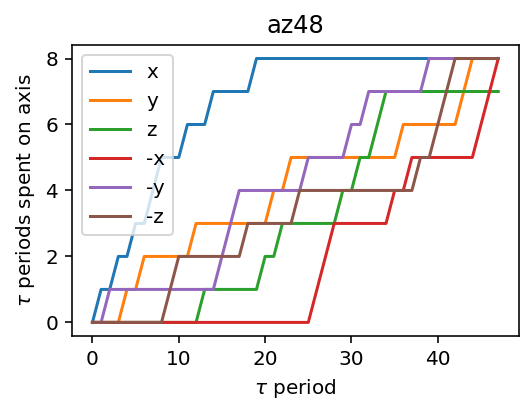

In [118]:
plt.plot(counts)
plt.title('az48')
plt.xlabel(r'$\tau$ period')
plt.ylabel(r'$\tau$ periods spent on axis')
plt.legend(['x', 'y', 'z', '-x', '-y', '-z'])

In [111]:
counts = [ps.count_axes(ps.az48_3[:i]) for i in range(len(ps.az48_3))]

In [112]:
counts = np.array(counts)

In [113]:
np.max(counts, axis=1) - np.min(counts, axis=1)

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1])

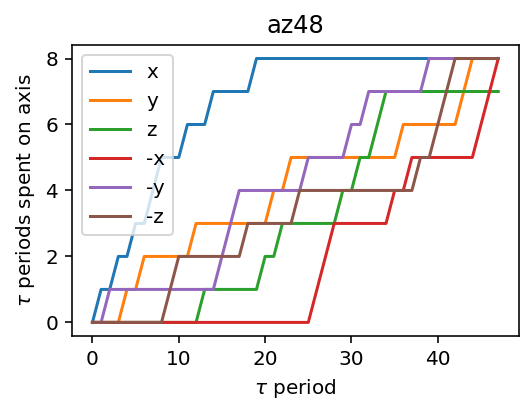

In [119]:
plt.plot(counts)
plt.title('az48')
plt.xlabel(r'$\tau$ period')
plt.ylabel(r'$\tau$ periods spent on axis')
plt.legend(['x', 'y', 'z', '-x', '-y', '-z'])

In [88]:
counts = [ps.count_axes(ps.cory48[:i]) for i in range(len(ps.cory48))]

In [90]:
counts = np.array(counts)

In [96]:
np.max(counts, axis=1) - np.min(counts, axis=1)

array([0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 1, 1, 2, 2, 2, 2, 3, 3, 4,
       4, 4, 4, 5, 5, 5, 5, 4, 3, 3, 3, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 5,
       5, 5, 5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 1])

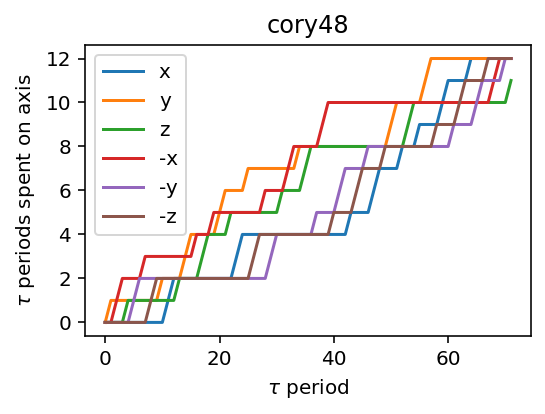

In [101]:
plt.plot(counts)
plt.title('cory48')
plt.xlabel(r'$\tau$ period')
plt.ylabel(r'$\tau$ periods spent on axis')
plt.legend(['x', 'y', 'z', '-x', '-y', '-z'])

In [107]:
counts = [ps.count_axes(ps.yxx48[:i]) for i in range(len(ps.yxx48))]

In [108]:
counts = np.array(counts)

In [109]:
np.max(counts, axis=1) - np.min(counts, axis=1)

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 4, 4, 4, 3, 3, 3, 2, 2, 2,
       1, 1, 1, 1])

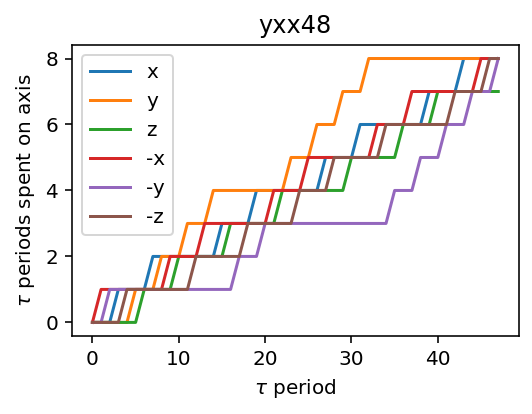

In [110]:
plt.plot(counts)
plt.title('yxx48')
plt.xlabel(r'$\tau$ period')
plt.ylabel(r'$\tau$ periods spent on axis')
plt.legend(['x', 'y', 'z', '-x', '-y', '-z'])

Looks like cory48 doesn't refocus interactions all that frequently... But it keeps it relatively close, so you don't spend a lot of time on one particular axis. 

In [100]:
print(ps.cory48)

[1, 3, 0, 2, 3, 0, 1, 3, 0, 1, 3, 0, 1, 4, 0, 1, 3, 0, 4, 2, 0, 3, 2, 0, 4, 2, 0, 4, 2, 0, 4, 1, 0, 4, 2, 0, 2, 3, 0, 2, 4, 0, 2, 3, 0, 1, 4, 0, 2, 4, 0, 1, 4, 0, 3, 2, 0, 3, 1, 0, 3, 2, 0, 4, 1, 0, 3, 1, 0, 4, 1, 0]


## Getting tensorboard data

In [10]:
import torch

In [21]:
# import tensorflow as tf
import tensorboard as tb

In [1]:
import tensorboard.backend.event_processing as ep

In [2]:
import tensorboard.backend.event_processing.event_file_loader as efl

In [3]:
loader = efl.EventFileLoader('../../data/2021-03/20210306-223124/Mar06_22-31-24_m20.hpcc.dartmouth.edu/events.out.tfevents.1615087884.m20.hpcc.dartmouth.edu.26520.0')

In [4]:
events = []
for event in loader.Load():
    events.append(event)

In [5]:
len(events)

30096

In [6]:
hist_events = [a for a in events if 'hist' in str(a)]

In [8]:
a = hist_events[3].summary.value[0]

In [28]:
a = hist_events[0].summary.value[0].histo

In [29]:
len(a.bucket), len(a.bucket_limit)

(0, 0)

In [89]:
hist_events[0].step

0

In [30]:
steps, buckets, bucket_limits = zip(*[
    (a.step, a.summary.value[0].histo.bucket, a.summary.value[0].histo.bucket_limit)
    for a in hist_events
])

In [93]:
# TODO write the histogram data to a file
# TODO also figure out if I can make a video animating histogram over time...

In [31]:
import matplotlib.pyplot as plt

/Users/willkaufman/opt/anaconda3/envs/rl_pulse/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


IndexError: tuple index out of range

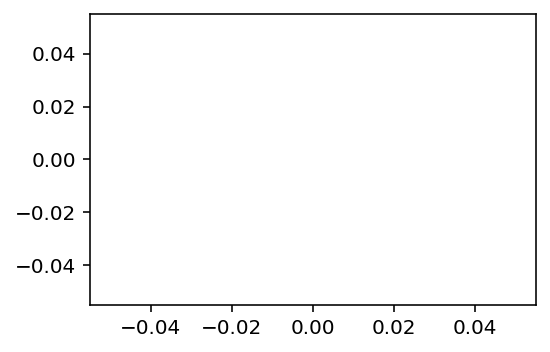

In [32]:
plt.hist(bucket_limits[0], bins=20, weights=buckets[0], range=(-1, 7),
         density=True, alpha=0.5, label='0')
plt.hist(bucket_limits[100], bins=20, weights=buckets[100], range=(-1, 7),
         density=True, alpha=0.5, label='1000')
plt.hist(bucket_limits[400], bins=20, weights=buckets[400], range=(-1, 7),
         density=True, alpha=0.5, label='4000')
plt.legend(title='Training step')
plt.title('-log(1 - fidelity)')
plt.show()

In [119]:
len(bucket_limits)

486

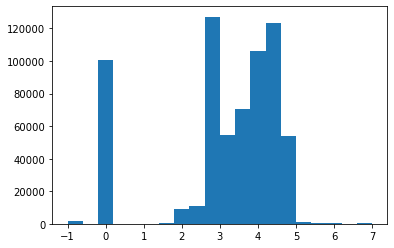

In [123]:
plt.hist(bucket_limits[100], bins=20, weights=buckets[100], range=(-1, 7))
plt.show()

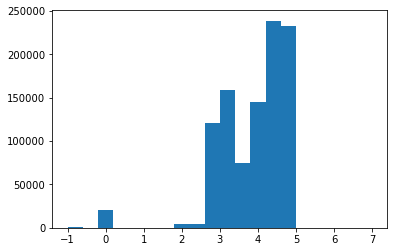

In [127]:
plt.hist(bucket_limits[200], bins=20, weights=buckets[200], range=(-1, 7))
plt.show()

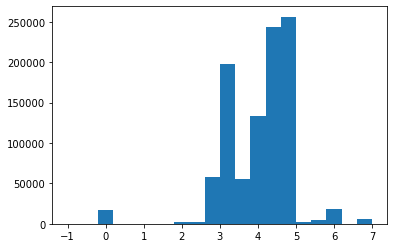

In [118]:
plt.hist(bucket_limits[-1], bins=20, weights=buckets[-1], range=(-1, 7))
plt.show()